In [1]:
import torch
from collections import Counter
# model
from models import GCNEdgeClassifier, ChebEdgeClassifier
# val
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef
# plot
import seaborn as sns
import matplotlib.pyplot as plt
# 
from torch import nn

In [2]:
plt.style.use('seaborn-whitegrid')

## Data

In [3]:
fold_idx = 2

In [4]:
train_data = torch.load(f'../../data/graph_designer/train_test_edge_classification_days/train_data_{fold_idx}.pt')
test_data  = torch.load(f'../../data/graph_designer/train_test_edge_classification_days/test_data_{fold_idx}.pt')
train_data 

Data(x=[2812, 7], edge_index=[2, 3784], edge_attr=[3784, 1], edge_label=[3784, 2])

In [5]:
test_data

Data(x=[2812, 7], edge_index=[2, 421], edge_attr=[421, 1], edge_label=[421, 2])

In [6]:
# 0: alto, 1: baixo
Counter(train_data.edge_label.argmax(dim=1).numpy())

Counter({0: 1839, 1: 1945})

In [7]:
# 0: alto, 1: baixo
Counter(test_data.edge_label.argmax(dim=1).numpy())

Counter({1: 210, 0: 211})

In [8]:
#train_data.edge_label = train_data.edge_label.argmax(dim=1).view(-1)
#test_data.edge_label = test_data.edge_label.argmax(dim=1)

In [9]:
train_data.edge_label.shape

torch.Size([3784, 2])

In [10]:
#train_data.edge_label

In [11]:
#train_data.edge_label.resize(train_data.edge_label.size(), 1)

## Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = GCNEdgeClassifier(train_data.num_features, 64, train_data.edge_label.shape[1]).to(device)
model = ChebEdgeClassifier(train_data.num_features, 64, train_data.edge_label.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()
#m = nn.Sigmoid()
model

ChebEdgeClassifier(
  (conv1): ChebConv(7, 64, K=3, normalization=sym)
  (conv2): ChebConv(64, 64, K=3, normalization=sym)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [13]:
train_data.edge_attr.max()

tensor(6.0866)

In [14]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x.to(device), 
                train_data.edge_index.to(device),
                train_data.edge_attr.to(device))
    
    #x_sig = m(out.view(-1))
    
    loss = criterion(out, train_data.edge_label.to(device))
    
    loss.backward()
    optimizer.step()
    return loss.item()

In [15]:
def test(data, tresh=0.3):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), 
                    data.edge_index.to(device),
                    data.edge_attr.to(device))
        
        pred = out.argmax(dim=1)
        true = data.edge_label.to(device).argmax(dim=1)
        
        # pred = [0 if x < tresh else 1 for x in x_sig]
        # true = data.edge_label.to(device).cpu().numpy()#.argmax(dim=1)
        
        return true, pred 

In [16]:
train_data.edge_label.to(device).flatten()

tensor([1., 0., 0.,  ..., 1., 0., 1.])

### Train

In [17]:
loss_scores = [train() for _ in range(100)]

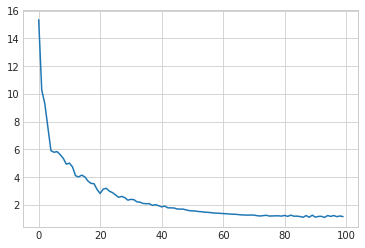

In [18]:
plt.plot(loss_scores)
plt.show()

### Test

In [19]:
y_true, y_pred = test(test_data, 0.5555)

### Validation

In [20]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute MCC
mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)

Confusion Matrix:
[[ 74 137]
 [ 58 152]]
MCC: 0.0803138244384553


In [21]:
accuracy = accuracy_score(y_true, y_pred) 
prec     = precision_score(y_true, y_pred, average='binary')
rec      = recall_score(y_true, y_pred, average='binary')
f1       = f1_score(y_true, y_pred, average='binary')

accuracy, prec, rec, f1

(0.5368171021377672,
 0.5259515570934256,
 0.7238095238095238,
 0.6092184368737474)

Classes:  Counter({0: 211, 1: 210})


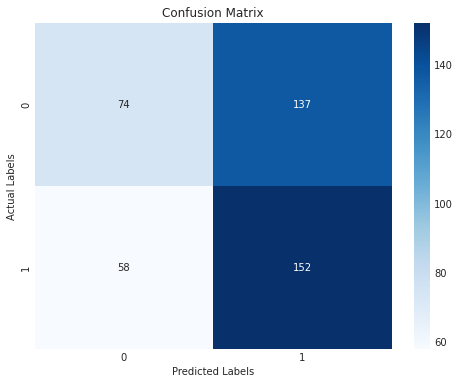

In [22]:
# Create a heatmap plot of the confusion matrix
keys = Counter(y_true.numpy())
#keys = Counter(y_true)
print(f"Classes:  {keys}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=sorted(keys.keys()), 
            yticklabels=sorted(keys.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()